# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 7. Решающие деревья и случайные леса.


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**. Если вы строите интерактивные графики, их стоит прислать в формате html.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.




**Баллы за задание:**

* Задача 1 &mdash; 15 баллов
* Задача 2 &mdash; 50 баллов
* Задача 3 &mdash; 30 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [1]:
# Bot check

# HW_ID: fpmi_ad7
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

При решении задания используйте `sklearn`. Пропишите сюда необходимые импорты

In [3]:
import scipy.stats
import warnings
import graphviz
from tqdm import tqdm_notebook

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

sns.set(font_scale=1.5)

Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/trees.html">ноутбук</a> с занятия по решающим деревьям.

---
### Задача 1.

Перед обучением линейной регрессии вы могли совершать некоторые преобразования над признаками. Какие преобразования стоит совершить перед обучением решающего дерева?

В частности, ответьте на вопрос, имеет ли смысл примененять следующие преобразования:
* монотонные функции от одного признака;
* немонотонные функции от одного признака;
* линейные функции от нескольких признаков;
* нелинейные функции от нескольких признаков;
* стандартизация признаков;
* преобразования категориальных признаков.

Например, вместо/дополнительно признака $x_j$ рассматривать признак $f(x_j)$, для указанных выше типов функций.

- ###### монотонные/немонотонные функции от одного признака  
Не стоит, от этого может измениться показания метрики H, что нехорошо  
- ###### линейные  
Не стоит, т.к. тогда повысится шанс переобучения, линейные зависимости могут выявляться, и так дерево будет более приспособлено для конкретно данного датасета  
- ###### нелинейные  
Случай почти аналогичен с линейными, эта зависимость будет выявлена деревом, что может быт не нужно явно для test  
- ###### стандартизация  
Стандартизация может помочь, т.к. она в целом будет одинаково влиять на данные из train и test, но если разброс параметров будет оченбь высок это поможет уменьшить степень этого разброса, хотя опять же это может быть важно так что спорно  
- ###### Преобразования категориальных признаков 
Можно использовать например One-Hot encoding, но если это будет действительно важно то дерево выявит нужные зависимости  

---
### Задача 2.

Рассмотрим данные из <a href="https://miptstats.github.io/courses/ad_fivt/task6.html" target="_blank">предыдущего домашнего задания</a>. Скачайте данные и разделите их на три части &mdash; обучающую, валидационную и тестовую в соотношении 3:1:1.

Рассматривать будем только те признаки явных зависимостей между которыми не было выявлено в предыдущем ДЗ

In [4]:
data = pd.read_csv("Bike-Sharing-Dataset/day.csv")  
data = data[
    [
        "season",
        "mnth",
        "holiday",
        "weekday",
        "workingday",
        "weathersit",
        "atemp",
        "hum",
        "windspeed",
        "cnt"
    ]
]

In [5]:
def train_valid_test_split(data: pd.DataFrame):
    train, valid_test = train_test_split(data, test_size=0.4, shuffle=True)
    valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True)
    return train, valid, test

In [6]:
train, valid, test = train_valid_test_split(data)

Выполните необходимые преобразования признаков.

*Замечание.* Если в валидационной и/или тестовой частях есть "большие" выбросы, их стоит убрать. Наша модель не должна пытаться их предсказать, но в то же время выбросы вносят существенный вклад в значение метрики. 

In [7]:
def clean_from_emis(data: pd.DataFrame, q=0.1):
    df = data
    df = df[
        df["hum"].between(df["hum"].quantile(q), df["hum"].quantile(1 - q))
        & df["atemp"].between(df["atemp"].quantile(q), df["atemp"].quantile(1 - q))
        & df["windspeed"].between(
            df["windspeed"].quantile(q), df["windspeed"].quantile(1 - q)
        )
        & df["atemp"].between(df["atemp"].quantile(q), df["atemp"].quantile(1 - q))
    ]
    return df

In [8]:
valid, test = clean_from_emis(valid, 0.02), clean_from_emis(test, 0.02)

In [9]:
X_train, X_valid, X_test = (
    train.drop(["cnt"], axis=1),
    valid.drop(["cnt"], axis=1),
    test.drop(["cnt"], axis=1),
)
Y_train, Y_valid, Y_test = train[["cnt"]], valid[["cnt"]], test[["cnt"]]


Обучите решающее дерево глубины 3 и визуализируйте его. 

*Рекомендуется сохранить визуализацию в html и отправить ее вместе с решением.*

In [10]:
clf = DecisionTreeRegressor(criterion="absolute_error", max_depth=3)
clf.fit(X_train, Y_train)

predictions = clf.predict(X_valid)
y_true = Y_valid.to_numpy()[:, 0]

def mean_absolute_percentage_error(y_true, y_pred):
    return 100 * (np.abs(y_true - y_pred) / y_true).mean()


print("MSE:", round(metrics.mean_squared_error(y_true, predictions) ** 0.5, 2))
print("MAE:", round(metrics.mean_absolute_error(y_true, predictions), 2))
print("MAPE:", str(round(mean_absolute_percentage_error(y_true, predictions), 2)) + "%")

MSE: 1310.47
MAE: 1014.32
MAPE: 26.27%


In [11]:
import pydotplus

In [12]:
dot_data = export_graphviz(
    clf,
    out_file=None,
    feature_names=X_train.columns,
    class_names="cnt",
    filled=True,
    rounded=True,
    special_characters=True,
)
graphviz.Source(dot_data)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png("tree_3_depth.png")

True

Подберите оптимальное значение максимальной глубины дерева. Для этого обучите решающие деревья с выставленным значением соответствующего гиперпараметра и посчитайте ошибку предсказаний каждого из них на валидационной выборке. Постройте соответствующий график.

In [13]:
MAPE = []
MSE = []
MAE = []
max_max_depth = 30
for depth in range(1, max_max_depth):
    clf = DecisionTreeRegressor(max_depth=depth)
    clf.fit(X_train, Y_train)

    predictions = clf.predict(X_valid)
    y_true = Y_valid.to_numpy()[:,0]
    MAPE.append(round(mean_absolute_percentage_error(y_true, predictions), 2))
    MAE.append(round(metrics.mean_absolute_error(y_true, predictions), 0))
    MSE.append(round(metrics.mean_squared_error(y_true, predictions) ** 0.5, 2))

Оптимальный max_depath для каждой глубины:

Оптимальная глубина по MAPE:  4


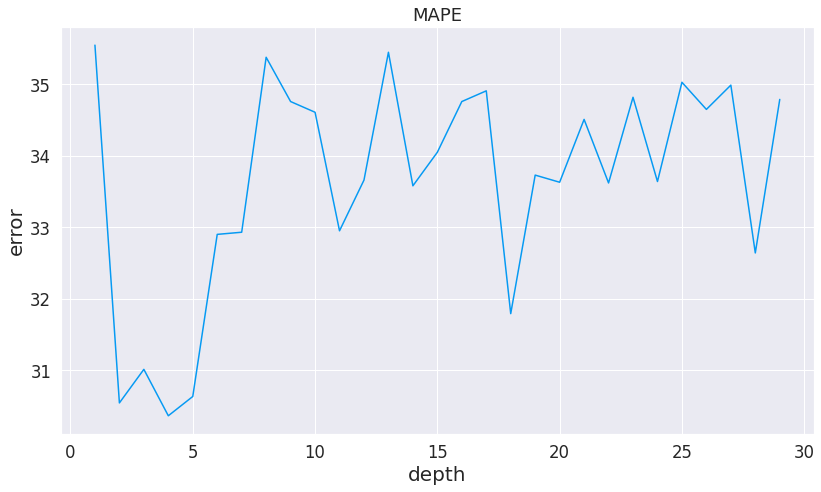

Оптимальная глубина по MAE:  4


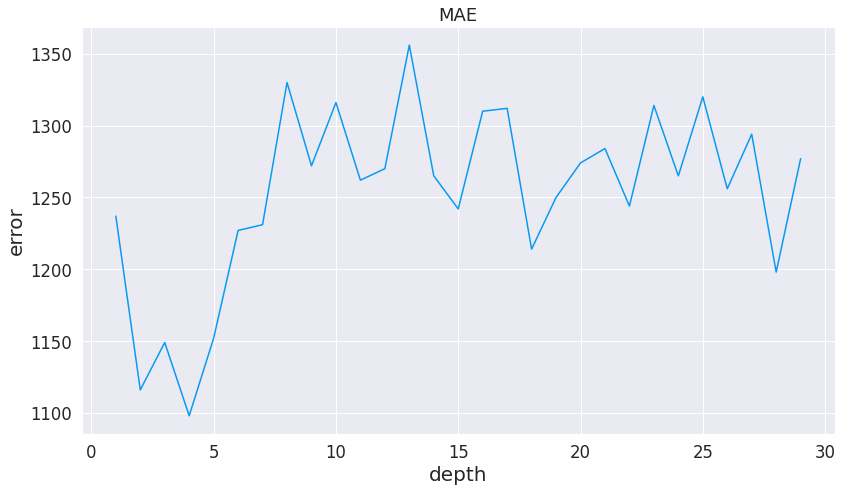

Оптимальная глубина по MSE:  4


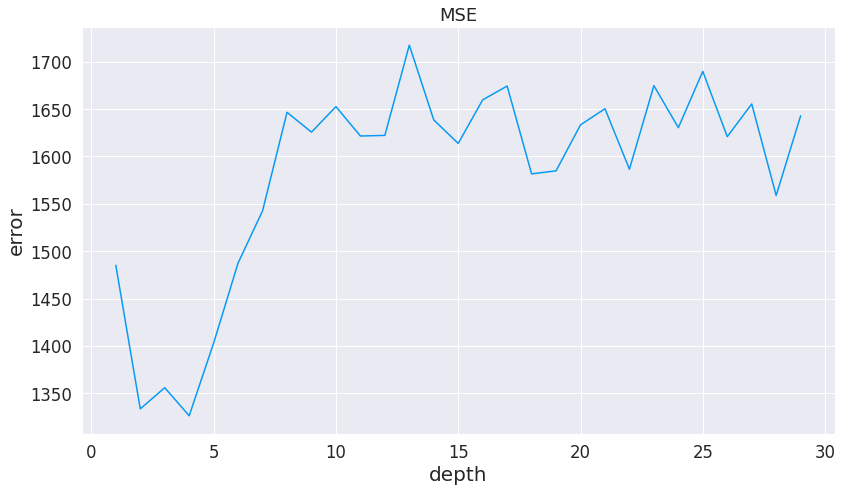

In [14]:
names = ["MAPE", "MAE", "MSE"]
error_metrics = [MAPE, MAE, MSE]
for name, metric in zip(names, error_metrics):
    print(f"Оптимальная глубина по {name}: ", np.argmin(metric) + 1)
    ax = sns.lineplot(y=metric, x=np.arange(1, max_max_depth), color="xkcd:azure")
    ax.figure.set_size_inches(13.5, 7.5)
    ax.set_xlabel("depth", fontsize=20)
    ax.set_ylabel("error", fontsize=20)
    plt.title(name)
    plt.show()
optimal_depth = np.argmin(MAPE) + 1

#### Краткие выводы из графика:  
- Значение оптимального значения гиперпараметра глубины очень близки на разных метриках  
- График ведет себя очень похоже на разных метриках что может сведетельствовать о том что оптимальное значение выбрано точно  
- На больших глубинах график колеблется на одних значениях  
- на каждом графике есть видимы спад в начале

Аналогичным образом подберите минимальное число объектов в листе, зафиксировав при этом подобранное значение максимальной глубины.

In [15]:
MAPE = []
MSE = []
MAE = []
max_min_leaf_volume = 50 
for leaf_volume in range(1, max_min_leaf_volume):
    clf = DecisionTreeRegressor(max_depth=optimal_depth, min_samples_leaf=leaf_volume)
    clf.fit(X_train, Y_train)

    predictions = clf.predict(X_valid)
    y_true = Y_valid.to_numpy()[:,0]
    MAPE.append(round(mean_absolute_percentage_error(predictions, y_true), 2))
    MAE.append(round(metrics.mean_absolute_error(predictions, y_true), 0))
    MSE.append(round(metrics.mean_squared_error(y_true, predictions) ** 0.5, 2))

Оптимальное значение мин числа объектов в листе по метрике MAPE:  31


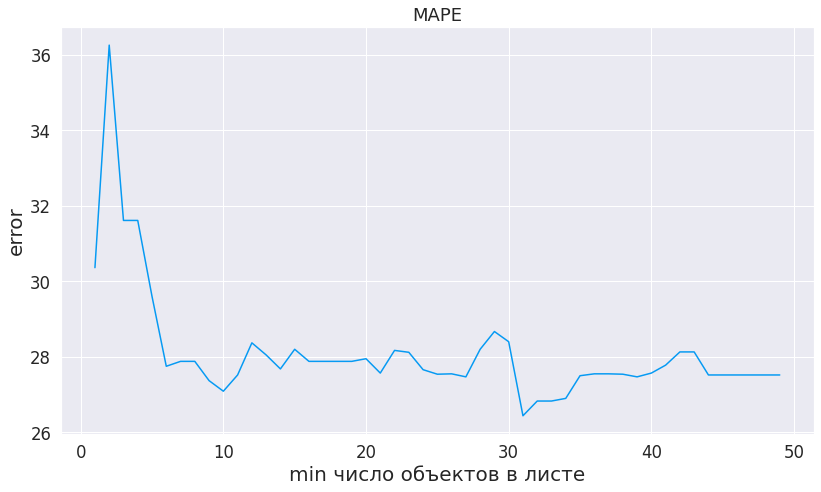

Оптимальное значение мин числа объектов в листе по метрике MAE:  25


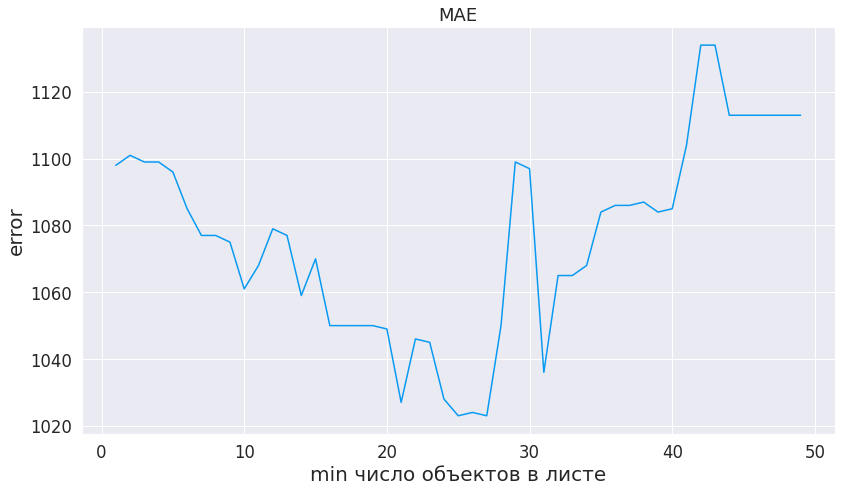

Оптимальное значение мин числа объектов в листе по метрике MSE:  25


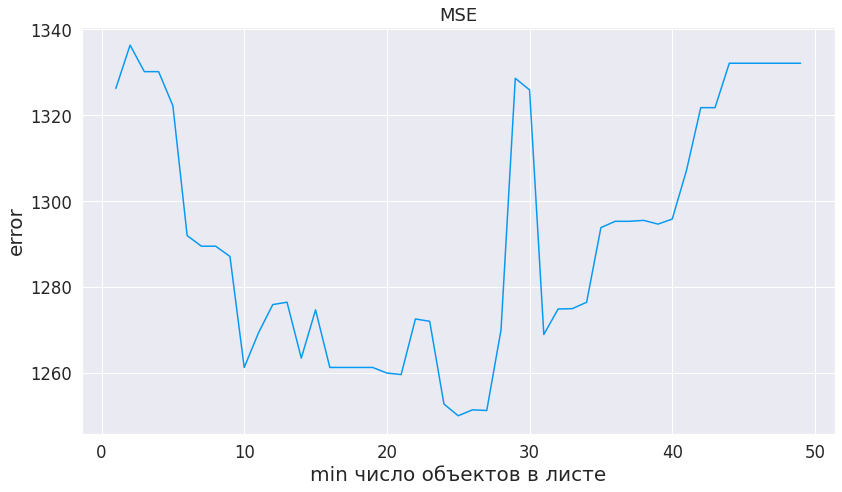

In [16]:
names = ["MAPE", "MAE", "MSE"]
error_metrics = [MAPE, MAE, MSE]
for name, metric in zip(names, error_metrics):
    print(
        f"Оптимальное значение мин числа объектов в листе по метрике {name}: ",
        np.argmin(metric) + 1,
    )
    ax = sns.lineplot(y=metric, x=np.arange(1, max_min_leaf_volume), color="xkcd:azure")
    ax.figure.set_size_inches(13.5, 7.5)
    ax.set_xlabel("min число объектов в листе", fontsize=20)
    ax.set_ylabel("error", fontsize=20)
    plt.title(name)
    plt.show()
optimal_min_samples_leaf = np.argmin(MAPE) + 1

#### Краткие выводы из графика: 
- Все графики сильно колеблятся, что значит о сильном влиянии данного параметра  
- Все графики дали ответ около 30 что может сведетельствовать об объективности  
- Поведение графиков сильно отличается  

Визуализируйте дерево при оптимальных гиперпараметрах и посчитайте его ошибку на тестовой части выборки.

In [17]:
clf = DecisionTreeRegressor(
    criterion="absolute_error",
    max_depth=optimal_depth,
    min_samples_leaf=optimal_min_samples_leaf,
)
clf.fit(X_train, Y_train)
dot_data = export_graphviz(
    clf,
    out_file=None,
    feature_names=X_train.columns,
    class_names="cnt",
    filled=True,
    rounded=True,
    special_characters=True,
)
graphviz.Source(dot_data)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png("optimal_tree.png")

True

Ошибка на тестовой части выборки:

In [18]:
predictions = clf.predict(X_test)
y_true = Y_test.to_numpy()[:, 0]

print("MSE:", round(metrics.mean_squared_error(y_true, predictions) ** 0.5, 2))
print("MAE:", round(metrics.mean_absolute_error(y_true, predictions), 2))
print("MAPE:", str(round(mean_absolute_percentage_error(y_true, predictions), 2)) + "%")

MSE: 1527.63
MAE: 1180.0
MAPE: 31.96%


Решающее дерево позволяет оценить *важность признаков* &mdash; некоторая величина, зависящая от того
* насколько часто тот или иной признак использовался при разбиении листа, 
* и насколько сильно при этом изменился критерий информативности.

У обученной модели значения важности признаков лежат в поле `feature_importances_`. Визуализируйте их с помощью `seaborn.barplot`.

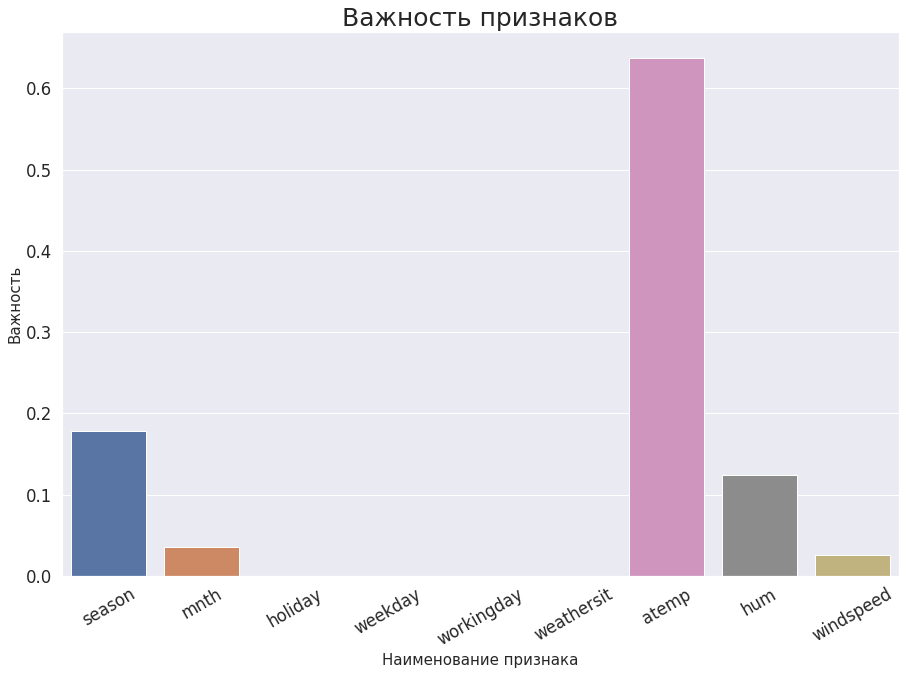

In [19]:
sns.set_style("darkgrid")
plt.figure(figsize=(15, 10))
features = [
    "season",
    "mnth",
    "holiday",
    "weekday",
    "workingday",
    "weathersit",
    "atemp",
    "hum",
    "windspeed",
]
sns.barplot(y=clf.feature_importances_, x=features)
plt.xticks(rotation=30)
plt.title("Важность признаков", fontsize=25)
plt.ylabel("Важность", fontsize=15)
plt.xlabel("Наименование признака", fontsize=15)
print()

Сделайте выводы.
- Самый важный признак для cnt - это температура (atemp)  
- Кроме того есть несколько признаков влияющих на ответ но очень слабо (см график)  
- сезон влияет очень мало(или вообще не влияет) а остальные врееменные признаки сами по себе не влияют на ответ

---
### Задача 3.

Для данных из предыдущей части обучите случайный лес на 500 деревьев.

In [20]:
n_estimators = 500
model = RandomForestRegressor(n_estimators=n_estimators)
y_train = Y_train['cnt']
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500)

In [21]:
predictions = model.predict(X_valid)
y_true = Y_valid.to_numpy()[:, 0]
print("MSE:", round(metrics.mean_squared_error(y_true, predictions) ** 0.5, 2))
print("MAE:", round(metrics.mean_absolute_error(y_true, predictions), 2))
print("MAPE:", str(round(mean_absolute_percentage_error(y_true, predictions), 2)) + "%")

MSE: 1186.67
MAE: 982.96
MAPE: 26.21%


Постройте график зависимости ошибки модели в зависимости от количества деревьев для обучающей и валидационной выборок.

*Замечание.* Не нужно заново обучать лес каждый раз. Используйте у *обученной* модели поле `estimators_`, это список из объектов класса `DecisionTreeRegressor`. Обратите внимание, что это приватное поле объекта, и менять его очень плохо, за такое баллы будут снижаться.

In [22]:
warnings.filterwarnings("ignore")

In [23]:
def get_errors_from_tree_num(X: pd.DataFrame, Y: pd.DataFrame):
    train_predictions = []
    MAPE = []
    MAE = []
    MSE = []
    y_true = Y.to_numpy()[:, 0]
    pref_sum = np.zeros(X.shape[0])
    for i in range(0, n_estimators):
        pref_sum += model.estimators_[i].predict(X)
        MAPE.append(mean_absolute_percentage_error(y_true, pref_sum / (i + 1)))
        MAE.append(metrics.mean_absolute_error(y_true, pref_sum / (i + 1)))
        MSE.append(metrics.mean_squared_error(y_true, pref_sum / (i + 1)))
    return np.array(MAPE), np.array(MAE), np.array(MSE)

In [24]:
train_metrics = get_errors_from_tree_num(X = X_train, Y=Y_train)
valid_metrics = get_errors_from_tree_num(X=X_valid, Y=Y_valid)

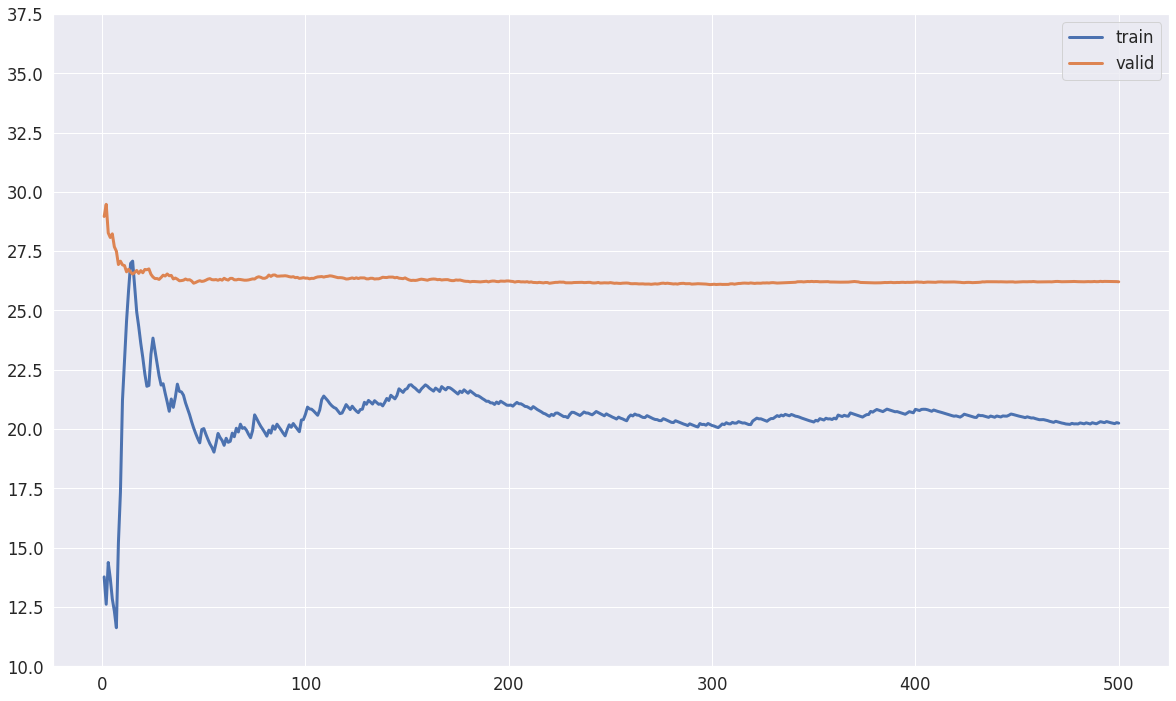

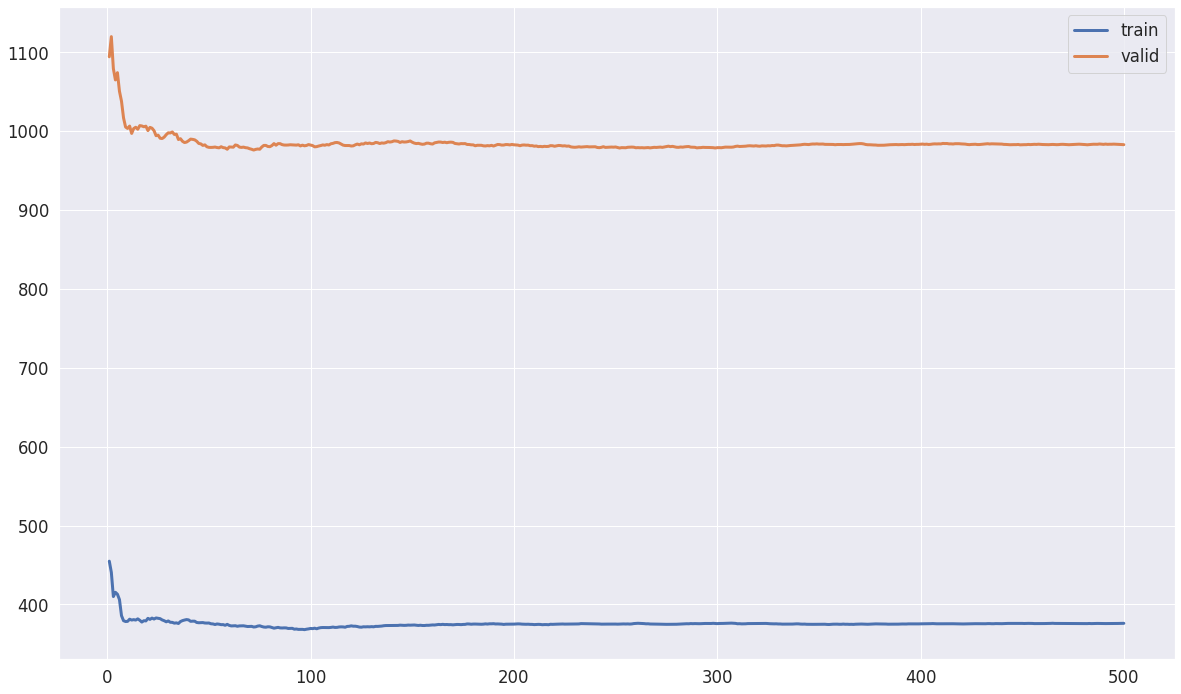

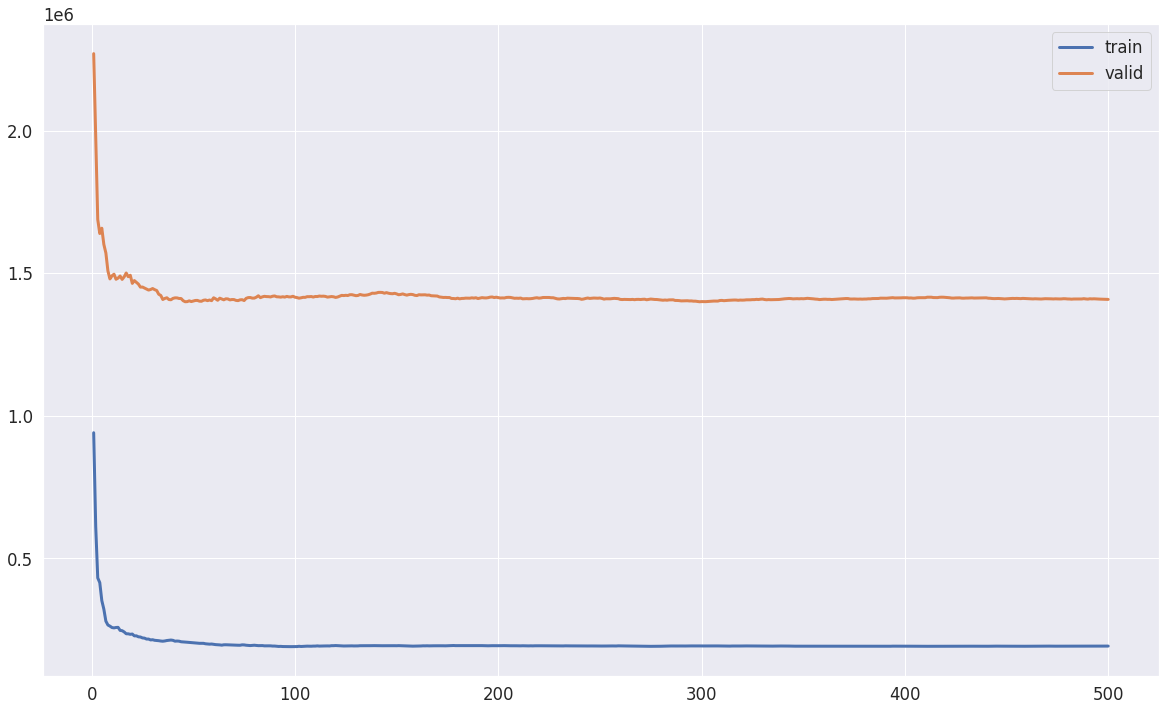

In [25]:
error_names = ["MAPE", "MAE", "MSE"]
for i, name in enumerate(error_metrics):
    plt.subplots(figsize=(20, 12))
    sns.lineplot(
        y=train_metrics[i], x=np.arange(1, n_estimators + 1), label="train", lw=3
    )
    sns.lineplot(
        y=valid_metrics[i], x=np.arange(1, n_estimators + 1), label="valid", lw=3
    )
    if i == 0:
        plt.yticks(np.arange(10, 40, step=2.5))
    plt.show()

#### Краткие выводы из графиков:
- В начале показания valid хуже остальных, а train сильно лучше, это сведетельствует о переобучении  
- (про MAPE) С течением времени видно что показатель train колеблется сильнее чем valid при этом колебания все меньше и меньше  
- с течением времени графики valid и train выходят на ассимптоту значит что лучший результат ошибки на valid достигнут


Для леса с максимальным количеством деревьев визуализируйте
важность признаков, используя поле `feature_importances_`. 

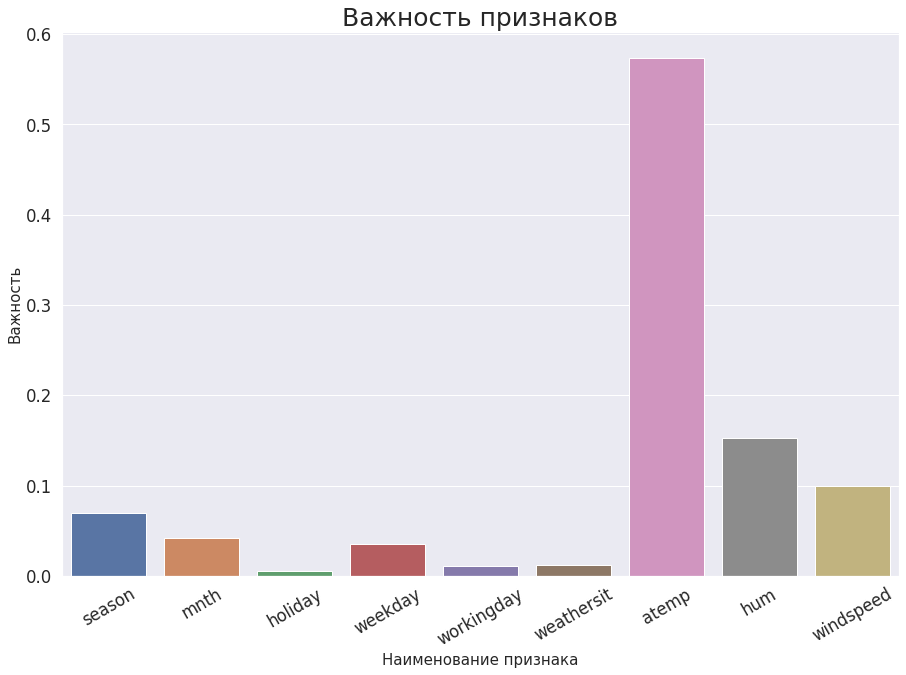

In [27]:
sns.set_style("darkgrid")
plt.figure(figsize=(15, 10))
features = [
    "season",
    "mnth",
    "holiday",
    "weekday",
    "workingday",
    "weathersit",
    "atemp",
    "hum",
    "windspeed",
]
sns.barplot(y=model.feature_importances_, x=features)
plt.xticks(rotation=30)
plt.title("Важность признаков", fontsize=25)
plt.ylabel("Важность", fontsize=15)
plt.xlabel("Наименование признака", fontsize=15)
print()

#### Краткие выводы из графика: 
- Лес выявил небольшие зависимости от многих параметров(взял из данных все что можно), что может сведетельствовать о том, что от этих параметров небольшая зависимостт все-таки есть(но возможно так вышло изза тонкостей реализации)  
- atemp-самый важный параметр и чуть менее важны hum и windspeed  

Сделайте выводы.

- Лес справляется с предсказание сильно лучше дерева даже с оптимальными гиперпараметрами  
- При увеличении числа деревьев сильно лучше становится ответ  
- После построения леса и дерева легко понять какие признаки насколько влияют на результат  
